In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

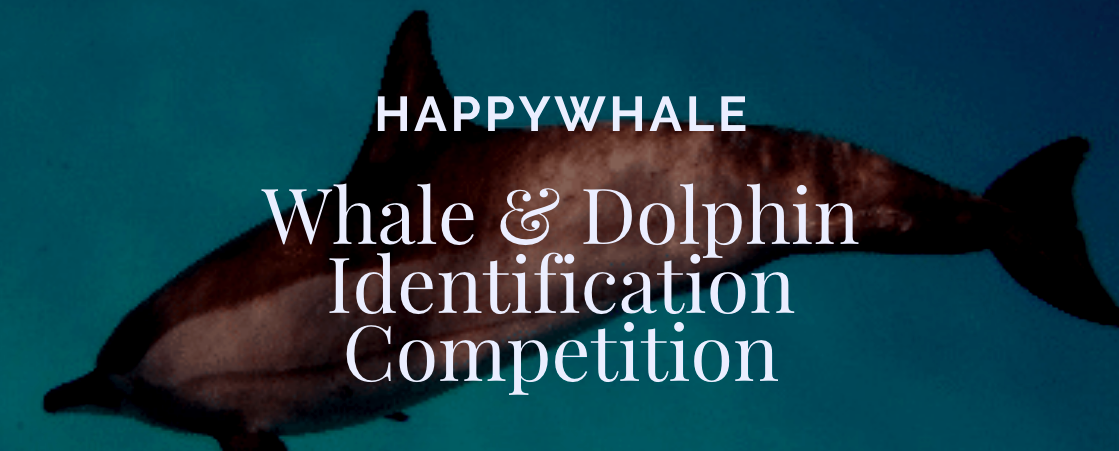

In [110]:
from IPython.display import Image as IPyImage

img = IPyImage('banner.png')
display(img)

# Happywhale Whale & Dolphin Identification Competition

## Highlights

* This project aims to build an accurate classifier for whales and dolphins using deep learning.
* Various architectures were compared, including two state-of-the-art architectures, LeViT192 and CoAtNet.
* Inception V3 had the best performance when top layers were unfrozen, allowing high learning rates even during fine-tuning

## Introduction and Motivation for the Study

Human beings can easily recognize one another by facial and bodily features, or alternatively through biometrics such as fingerprints. The same cannot be as easily said with animals, including sea creatures which are difficult to observe in full in the wild. Marine scientists track whales and dolphins through the shape and markings on visible body parts, such as their tails, fins, and heads, based on pictures taken during marine surveys. Such photographic identification allows tracking the location and migration patterns of individual animals over time, not to mention assessments of species health and population trends. However this is very challenging and time-consuming, not to mention prone to errors. In practice, manual comparison and matching of tens of thousands of photographs simply cannot be performed at scale.

This is where machine learning comes in, as image classification models allow for the automated identification of sea mammals, both in terms of species and individuals. To this end, **Happywhale**, a research collaboration and citizen science organization, not only collects photographic submissions of whales and dolphins, but also encourages the public develop innovative tools that aid in marine mammal research. Among their initiatives is to sponsor competitions on Kaggle, inviting data scientists to develop  and models that can automate photo identification, reducing time spent on photo identification by up to 99%.

Participants in the ongoing ***Happywhale Whale and Dolphin Identification Competition*** on Kaggle are tasked with training models on pictures primarily consisting of dorsal finds and lateral body views from multi-species datasets compiled by 28 different marine research institutions. This is not even the first such competition, as a previous similar initiative already resulted in a "*global database of over 50,000 whales and an agreement with cruise ships to operate at a maximum speed of 11 mph in the most whale-rich region*".

The motivation behind this study, in addition to familiarizing oneself better with computer vision models and architectures and gaining the experience and confidence that comes with joining a live AI competition, is to participate in a global citizen science efforts in building valuable tools to help in conversation research. As mentioned on the Kaggle contest page, "if there's a whale, there's a way!". [1] [2]

## Data Preparation and Pre-processing

### Downloading of the Dataset

As with any machine learning project, one of the first steps is to gather and consolidate the data. Data was downloaded from a version of the competition dataset with images resized to 384x384 pixels; although image reduction of the original images can be easily incorporated into the pipeline, storing of already-resized images would greatly help manage computational load and runtimes.

The necessary Python libraries were downloaded as well, and the random seed was set to help improve replicability.

In [1]:
# !pip install opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/rdizzl3/jpeg-happywhale-384x384")

In [100]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import random as rnd

import pickle
import random
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

seed = 143
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

### Initial Data Inspection and Cleaning 

Having obtained the data, a cursory inspection was performed. The `csv` file accompanying the images shows there are 3 columns: the image filename, species, and individual ID, for a total of 51,033 images available for training.

(No labels were provided for the test set; model performance on the holdout set of 27956 test images can only be evaluated by submitting predictions via Kaggle.)

In [34]:
print(f'Number of images in the train-val set: {len(df_train)}')
df_train.head()

Number of images in the train-val set: 51033


image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

Below is a summary breakdown of the images, according to the species label.

In [18]:
df_train = pd.read_csv('jpeg-happywhale-384x384/train.csv')
pd.DataFrame(df_train['species'].value_counts().sort_index())

species
beluga                        7443
blue_whale                    4830
bottlenose_dolphin            9664
bottlenose_dolpin             1117
brydes_whale                   154
commersons_dolphin              90
common_dolphin                 347
cuviers_beaked_whale           341
dusky_dolphin                 3139
false_killer_whale            3326
fin_whale                     1324
frasiers_dolphin                14
globis                         116
gray_whale                    1123
humpback_whale                7392
kiler_whale                    962
killer_whale                  1493
long_finned_pilot_whale        238
melon_headed_whale            1689
minke_whale                   1608
pantropic_spotted_dolphin      145
pilot_whale                    262
pygmy_killer_whale              76
rough_toothed_dolphin           60
sei_whale                      428
short_finned_pilot_whale       367
southern_right_whale           866
spinner_dolphin               1700
spotted_dolphin                490
white_sided_dolphin            229

The table above shows a few misspellings and redundancies. Specifically, there are mispellings such as "bottlenose_dolpin" and "kiler_whale". Also, both "globis" and "pilot whale" are alternative names for the short-finned pilot whale. These are corrected in the dataset accordingly, and the revised summary is shown below.

In [30]:
df_train['species'].replace({"globis": "short_finned_pilot_whale",
                             "pilot_whale": "short_finned_pilot_whale",
                             "kiler_whale": "killer_whale",
                             "bottlenose_dolpin": "bottlenose_dolphin"},
                            inplace=True)

train_species_count = df_train['species'].value_counts().sort_index()
pd.DataFrame(train_species_count)

species
beluga                        7443
blue_whale                    4830
bottlenose_dolphin           10781
brydes_whale                   154
commersons_dolphin              90
common_dolphin                 347
cuviers_beaked_whale           341
dusky_dolphin                 3139
false_killer_whale            3326
fin_whale                     1324
frasiers_dolphin                14
gray_whale                    1123
humpback_whale                7392
killer_whale                  2455
long_finned_pilot_whale        238
melon_headed_whale            1689
minke_whale                   1608
pantropic_spotted_dolphin      145
pygmy_killer_whale              76
rough_toothed_dolphin           60
sei_whale                      428
short_finned_pilot_whale       745
southern_right_whale           866
spinner_dolphin               1700
spotted_dolphin                490
white_sided_dolphin            229

Of course, data inspection will not be complete without examining a sample of the images themselves, to get an idea of what the models will be classifying.

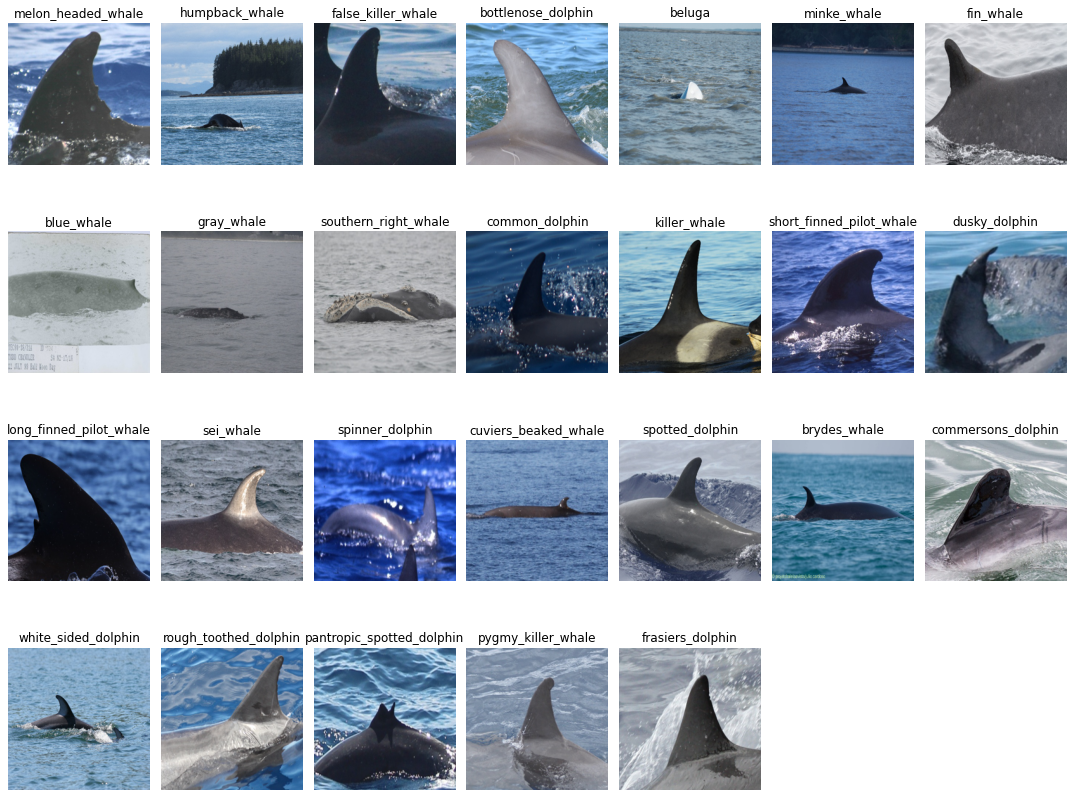

In [39]:
df_train['path'] = ('./jpeg-happywhale-384x384/train_images/' +
                    df_train['image'])

plt.figure(figsize = (15,12))
for idx, i in enumerate(df_train.species.unique()):
    plt.subplot(4,7, idx + 1)
    df = df_train[df_train['species'] == i].reset_index(drop = True)
    image_path = df.loc[rnd.randint(0, len(df))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

## Data Exploration

Next, visualization and image rendering tools were applied to perform exploratory data analysis. This begins with a bar plot of the species count distribution for the 26 different whale and dolphin species in the dataset, followed by a computation of a baseline accuracy needed based on the PCC.

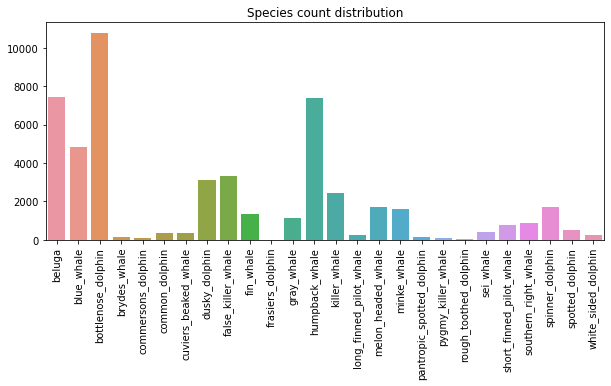

In [22]:
train_val_count = (df_train['species'].value_counts().
                   sort_index())

fig, ax = plt.subplots(figsize=(10, 4))

chart = sns.barplot(x=train_val_count.index,
                    y=train_val_count.values, ax=ax)
ax.set_title('Species count distribution')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [125]:
print(f'Number of species: {len(train_val_count)}')
print(f'PCC x 1.25 = '
      f'{1.25 * sum(df_train["species"].value_counts(normalize=True)**2):.4%}')

Number of species: 26
PCC x 1.25 = 13.9199%


Next, an exploration was performed on the individual ID distribution. A quick query reveals that there are 15,587 individual animal labels, resulting in a very low PCC of well under 0.1%.

In [127]:
ind_count = df_train['individual_id'].nunique()
print(f"Number of individuals: {ind_count}")
print(f'PCC x 1.25 = '
      f'{1.25 * sum(df_train["individual_id"].value_counts(normalize=True)**2):.4%}')

Number of individuals: 15587
PCC x 1.25 = 0.0719%


The number of individuals are not necessarily proportional to the number of images for that particular species. Comparing the plot above with that below, it may be observed for example that there are nearly 7,443 images for the beluga whale, but they correspond to only about 1,012 individuals. In contrast, there are nearly 10,781 images for the bottlenose dolphin, but these correspond to even less individuals, only 904. Meanwhile, for the dusky dolphin, almost every individual has only one available picture, with 3,139 images taken of 2,731 individuals.

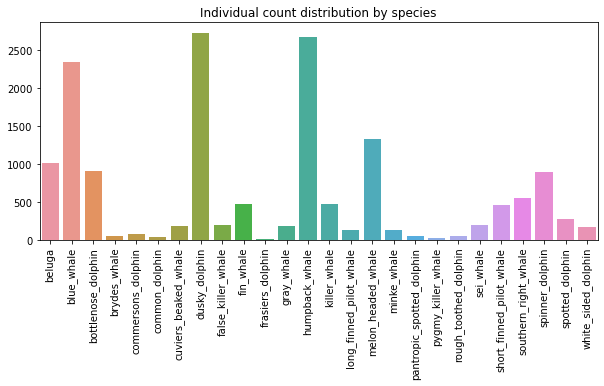

In [24]:
train_ind_count = df_train.groupby('species')['individual_id'].nunique()

fig, ax = plt.subplots(figsize=(10, 4))

chart = sns.barplot(x=train_ind_count.index, y=train_ind_count.values, ax=ax)
ax.set_xlabel(None)
ax.set_title('Individual count distribution by species')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [32]:
df_summary = pd.concat([pd.DataFrame(train_species_count),
                        pd.DataFrame(train_ind_count)],
                       axis=1)
df_summary.columns = ['species_count', 'individual_count']
df_summary

species_count  individual_count
beluga                              7443              1012
blue_whale                          4830              2348
bottlenose_dolphin                 10781               904
brydes_whale                         154                44
commersons_dolphin                    90                70
common_dolphin                       347                38
cuviers_beaked_whale                 341               183
dusky_dolphin                       3139              2731
false_killer_whale                  3326               196
fin_whale                           1324               466
frasiers_dolphin                      14                13
gray_whale                          1123               185
humpback_whale                      7392              2679
killer_whale                        2455               472
long_finned_pilot_whale              238               131
melon_headed_whale                  1689              1323
minke_whale                         1608               128
pantropic_spotted_dolphin            145                44
pygmy_killer_whale                    76                24
rough_toothed_dolphin                 60                46
sei_whale                            428               197
short_finned_pilot_whale             745               458
southern_right_whale                 866               549
spinner_dolphin                     1700               891
spotted_dolphin                      490               280
white_sided_dolphin                  229               175

It is perhaps not so surprising that while a few individuals may have numerous photographs, most individuals have only very few images available, in many cases just one.

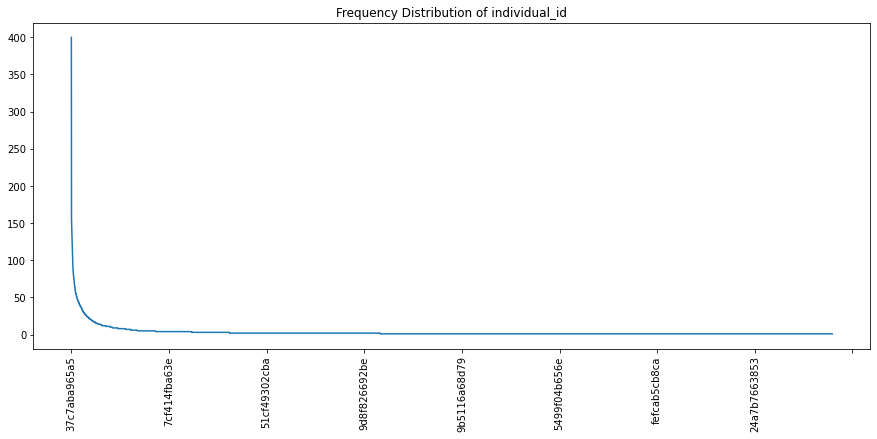

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))
df_train['individual_id'].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Frequency Distribution of individual_id')
plt.show()

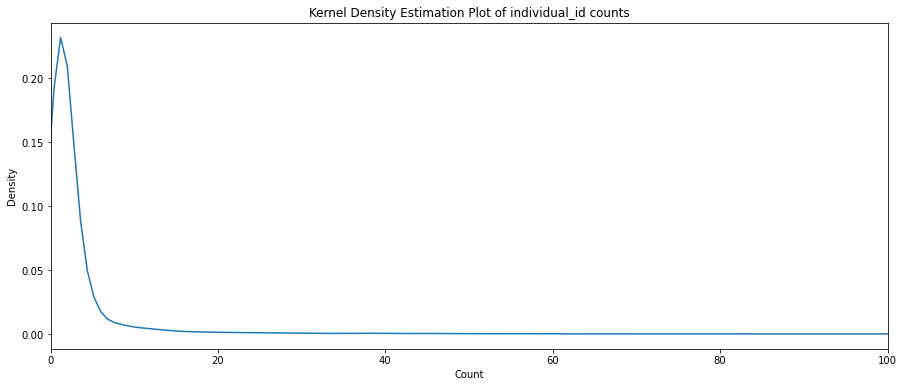

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))
df_train['individual_id'].value_counts().plot.kde()
plt.xlim(0, 100)
plt.xlabel('Count')
plt.title('Kernel Density Estimation Plot of individual_id counts')
plt.show()

## Comparison and Evaluation of Deep Learning Architectures

As seen in the data exploration, the dataset allows for either species identification or individual identification. It was decided that the study would have species identification as its primary focus, to build expertise and confidence on computer vision architectures by applying them on a more manageable use case involving 26 class labels.

It may be noted that the Kaggle competition is geared more towards individual identification. With over 15,000 different individuals this was considered to be a secondary priority given the time available. The plan would be to compare different deep learning models and dentify the model that performs best on species identification, then seek to retrain it for individual identification and submit predictions on the test set to Kaggle.

The deep learning architectures to be considered included three well-established models available from Keras for transfer learning, namely VGG16, Inception V3, and EfficientNet B0. These would be compared against two state-of-the-art architectures, namely LeViT 192 and CoAtNet 0, both of which are hybrid models that combine convolutional networks with image transformers to apply attention mechanisms. All of these would be compared against a custom CNN to be used as a baseline.

Specific variants of the architectures were chosen based on the number of parameters, to make the models roughly comparable in complexity. Another consideration was the specific image sizes on which the models were originally pre-trained, as this study would mainly be training on 224x224 to 256x256 images (as higher resolutions were observed to make the runtimes prohibitively). A final consideration was the possibility of transfer learning. For the first 3 models, these were already available from Keras, along with weights trained on Imagenet. For the newer hybrid models of LeViT and CoAtNet, the weights were available from third-party sources on GitHub.


| **Architecture**    | **Description**                                                                                                                 | **Introduced** |
|---------------------|---------------------------------------------------------------------------------------------------------------------------------|----------------|
| **Baseline CNN**    | A straightforward custom convolutional neural networks with max pooling                                                         | 1980's         |
| **VGG16**           | Popular CNN for transfer learning with increased depth and small (3x3) convolution filters                                      | 2014           |
| **Inception V3**    | Scaled-up CNN aiming to be as efficient as possible by suitably factorized convolutions and aggressive regularization           | 2016           |
| **EfficientNet B0** | Conditionally parameterized convolutions, which learn specialized convolutional kernels for each sample for efficient inference | 2019           |
| **LeViT 192**       | A hybrid using vision transformers, employing activation maps with decreasing resolutions and attention bias for fast inference | 2021 May       |
| **CoAtNet 0**       | Marries CNN and Transformers to improve both generalization and model capacity                                                  | 2021 Sep       |


### Parameters

To facilitate coding, various model parameters and global variables, such as the target column, the number of classes, the input resolution size, the working folders, and the batch size would be set.

In [61]:
work_dir = "./jpeg-happywhale-384x384"
save_dir = "./savefiles"
train_folder = "train_images"
test_folder = "test_images"
img_col = "image"
label_col = "individual_id"
specie_col = "species"

target_col = specie_col
num_classes = len(df_train[target_col].value_counts())

batch_size = 64
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size
epochs = 4
target_size = 256

In [62]:
print('Checking number of images in train and test folders:')
# print(os.listdir(WORK_DIR))
print('Train images: %d' %len(os.listdir(
    os.path.join(work_dir, train_folder))))
print('Test images: %d' %len(os.listdir(
    os.path.join(work_dir, test_folder))))

Checking number of images in train and test folders:
Train images: 51033
Test images: 27956


In [15]:
specie_names = df_train['species'].value_counts().index
specie_idx_map = {specie: idx for idx, specie in enumerate(specie_names)}
idx_specie_map = {idx: specie for specie, idx in specie_idx_map.items()}

label_names = df_train['individual_id'].value_counts().index
label_idx_map = {label: idx for idx, label in enumerate(label_names)}
idx_label_map = {idx: label for label, idx in label_idx_map.items()}

df_train["species_idx"] = df_train['species'].map(specie_idx_map)
df_train["individual_idx"] = df_train['individual_id'].map(label_idx_map)

### Preparation of Data Generators and Data Augmentation

Due to slight differences in the pre-processing requirements for the various models, different `ImageDataGenerator` objects were built. For instance, the baseline CNN model would required require rescaling of pixel values to between 0 and 1, but the Keras models came with their own customized `preprocessing_function`s, which would already take care of rescaling. Also the LeViT and CoAtNet models from Github required an input image size of 224x224, only slightly lower than the 256x256 resolution used by the other models.

#### For Baseline CNN Model

In [79]:
# Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   preprocessing_function=None,
                                   rotation_range=45,
                                   zoom_range=0.2,
                                   brightness_range=[0.6, 1.4],
                                   channel_shift_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   shear_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1)

train_generator = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

val_generator = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### For Inception V3, VGG16, and EfficientNet B0

In [26]:
# Training set
unscaled_train_datagen = ImageDataGenerator(validation_split=0.2,
                                            preprocessing_function=None,
                                            rotation_range=45,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.4],
                                            channel_shift_range=0.7,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='nearest',
                                            shear_range=0.1,
                                            height_shift_range=0.1,
                                            width_shift_range=0.1)

unscaled_train_gen = (
    unscaled_train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
unscaled_val_datagen = ImageDataGenerator(validation_split=0.2)

unscaled_val_gen = (
    unscaled_val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### For LeViT and CoAtNet

In [54]:
alt_target_size = 224

alt_train_gen = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(alt_target_size, alt_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

alt_val_gen = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(alt_target_size, alt_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


Also, for all models, data augmentation would be used as a pre-processing step in the pipeline to improve each model's ability to generalize and avoid overfitting. Below is a visualization of what generated images may look like after applying augmentation techniques, which include zoom, rotation, shear,  flipping, and shifts in brightness, channel, height, and width. The leftmost column consists of the original images, while the remaining columns comprise the transformed images. The pictures were taken under a wide array of conditions,  (some even taken underwater), so a wide net was cast when it came to data augmentation.

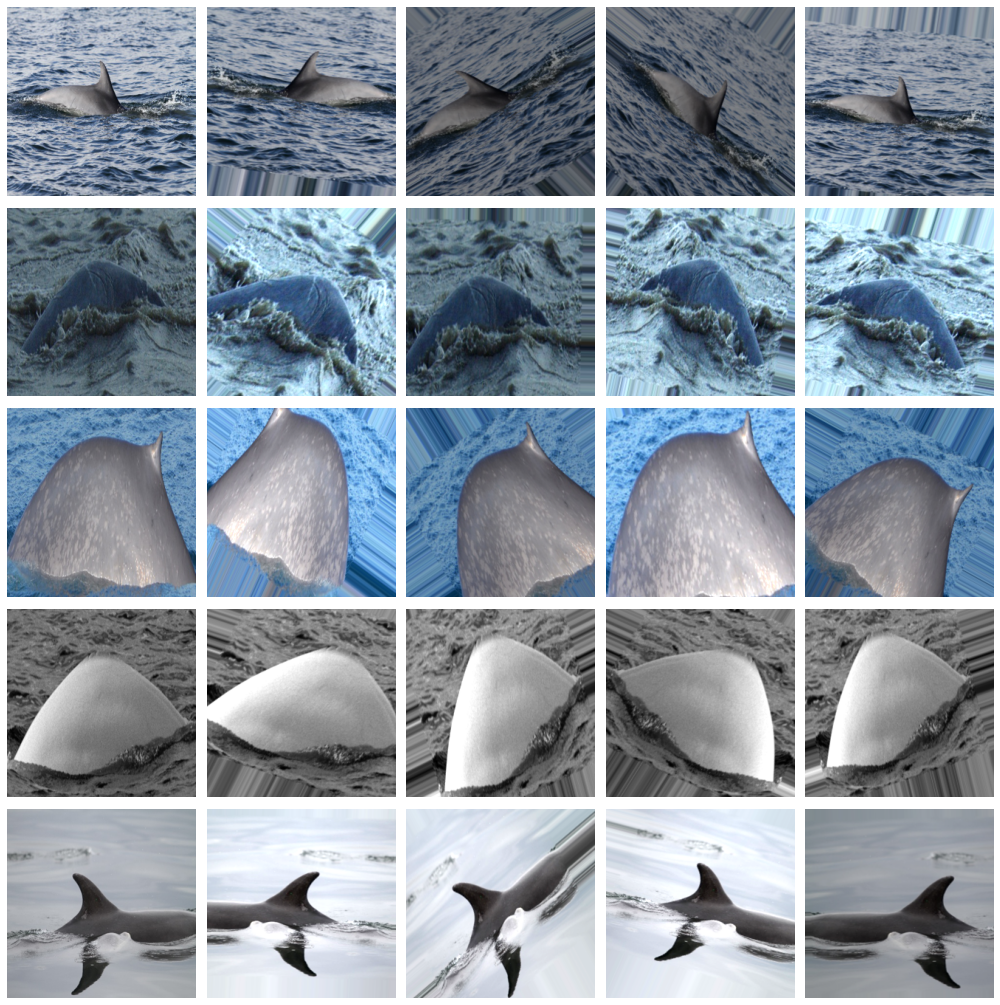

In [81]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.title('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((target_size, target_size))
        samples = np.expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10, 5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10, 5, midx+1)
            
            batch = it.next()
            image = batch[0]
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

plot_augimages(np.random.choice(df_train['path'], 5), train_datagen)

### Baseline CNN Model

As mentioned, the baseline model would be a standard CNN architecture consisting of 3 blocks. The first block would utilize a Conv2D layer, batch normalization, and max pooling. The second block would have another Conv2D layer followed again by max pooling.

The topmost block would flatten the output of the previous layer, incorporate a dense hidden layer of 256 hidden nodes, a dropout layer with a rate of 0.6, and then an output layer with a width equal to the number of class labels.

All activation functions would be `relu`, except for the output layer which utilizes `softmax`. The loss function would be `categorical cross-entropy`, the optimizer would be `adam`, and `categorical accuracy` would be used as an initial performance metric.

The architecture of the final output block and the other model parameters would be left generally consistent across all the models to be evaulated in this study, with only minor variations to improve performance based on iterations and trial and error.

#### Training

Below are a summary of the model layers, as well as the model performance after training and cross-validation across 4 epochs.

In [19]:
tf.keras.backend.clear_session()

In [20]:
base_cnn = models.Sequential()

base_cnn.add(layers.Conv2D(filters=32, kernel_size=6, strides=1, padding='same',
                 input_shape=(target_size, target_size, 3)))
base_cnn.add(layers.BatchNormalization(axis=3))
base_cnn.add(layers.Activation('relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

base_cnn.add(layers.Conv2D(filters=64, kernel_size=3, strides=1,  padding='same',
                        activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(3, 3)))

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(256, activation="relu"))
base_cnn.add(layers.Dropout(0.6))

base_cnn.add(layers.Dense(num_classes, activation='softmax'))
base_cnn.summary()

base_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 112896)            0

In [21]:
%%time

filepath_cnn = save_dir + "/base_cnn_wts.hdf5"
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

base_cnn_history = base_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cnn]
)


Epoch 1/4
637/637 [==============================] - 1039s 2s/step - loss: 2.6146 - accuracy: 0.3360 - val_loss: 2.0659 - val_accuracy: 0.3733

Epoch 00001: val_accuracy improved from -inf to 0.37331, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1174s 2s/step - loss: 1.9758 - accuracy: 0.4090 - val_loss: 1.6577 - val_accuracy: 0.4988

Epoch 00002: val_accuracy improved from 0.37331 to 0.49882, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1042s 2s/step - loss: 1.8576 - accuracy: 0.4440 - val_loss: 1.7097 - val_accuracy: 0.4728

Epoch 00003: val_accuracy did not improve from 0.49882
Epoch 4/4
637/637 [==============================] - 1033s 2s/step - loss: 1.7764 - accuracy: 0.4661 - val_loss: 1.7056 - val_accuracy: 0.4897

Epoch 00004: val_accuracy did not improve from 0.49882
CPU times: user 1h 5min 48s, sys: 4min 40s, total: 1h 10min 29s
Wall time: 1h 11min 32s


In [22]:
base_cnn.load_weights(filepath_cnn)

base_cnn.save(save_dir + '/baseline_cnn.h5')

import pickle
with open(save_dir + '/baseline_cnn_hist.pickle', 'wb') as handle:
    pickle.dump(base_cnn_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

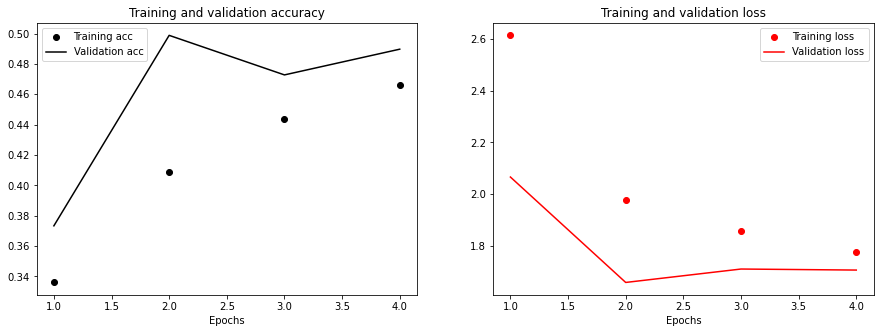

In [24]:
plot_results(base_cnn_history)

### Transfer Learning with Inception V3 + Fine-Tuning

Following the baseline CNN model, the other five models (Inception V3 [3], VGG16 [4], EfficientNet B0 [5], CoAtNet0 [6], and LeViT192 [7]) were trained as well, in no particular order, starting with Inception V3.

For the initial model architecture comparisons, 4 epochs were used for the initial training, with the base model fully frozen (as it had already been pre-trained on ImageNet), while the top layers (including the dense hidden layer of 256 nodes as well as the output layer) would be unfrozen to allow the model to adapt to the specific dataset.

After the initial training, some topmost layers in the base model would be unfrozen, and the learning greatly rate reduced to allow fine-tuning of the weights and hopefully an improvement in the model accuracy. The model would then be trained for an additional 4 epochs to allow fine-tuning. (An exception to this pattern is Inception V3, which based on iterations was discovered to continue to increase significantly in performance beyond 4 epochs. For this reason, during fine-tuning of Inception V3, the learning rate was still kept relatively high, to take advantage of its capacity for improvement.)

The number of epochs was chosen based on runtime considerations (it takes approx 1 hour to run 4 epochs), as well as trial-and-error observations; in the case of most models, there are only minimal gains after the 4th epoch without introducing fine-tuning.

Model performance plots would be generated after both the initial training as well as the fine-tuning.

In [25]:
tf.keras.backend.clear_session()

#### Training of the top layers

In [30]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = "imagenet")

inception_v3.trainable = False

model_inv3 = models.Sequential()
model_inv3.add(layers.Lambda(preprocess_inception_v3,
                             input_shape=(target_size, target_size, 3)))
model_inv3.add(inception_v3)
model_inv3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3.add(layers.Flatten())
model_inv3.add(layers.Dense(256, activation="relu"))
model_inv3.add(layers.Dropout(0.6))
model_inv3.add(layers.Dense(num_classes, activation='softmax'))

model_inv3.summary()

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)               

In [31]:
%%time

filepath_inv = save_dir + "/model_inv3_wts.hdf5"
checkpoint_inv = ModelCheckpoint(filepath_inv, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_inv3 = model_inv3.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv]
)

Epoch 1/4
637/637 [==============================] - 1030s 2s/step - loss: 2.4698 - accuracy: 0.3551 - val_loss: 1.5864 - val_accuracy: 0.5924

Epoch 00001: val_accuracy improved from -inf to 0.59240, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1095s 2s/step - loss: 2.0638 - accuracy: 0.4125 - val_loss: 1.4963 - val_accuracy: 0.6027

Epoch 00002: val_accuracy improved from 0.59240 to 0.60268, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 3/4
637/637 [==============================] - 973s 2s/step - loss: 1.9837 - accuracy: 0.4208 - val_loss: 1.4773 - val_accuracy: 0.6069

Epoch 00003: val_accuracy improved from 0.60268 to 0.60690, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 4/4
637/637 [==============================] - 954s 1s/step - loss: 1.9331 - accuracy: 0.4287 - val_loss: 1.5438 - val_accuracy: 0.5668

Epoch 00004: val_accuracy did not improve from 0.60690
CPU times: user 1h 2min 59s, sys: 4min 35s, total:

In [32]:
model_inv3.load_weights(filepath_inv)

model_inv3.save(save_dir + '/inception_v3.h5')

with open(save_dir + '/inception_v3_hist.pickle', 'wb') as handle:
    pickle.dump(history_inv3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

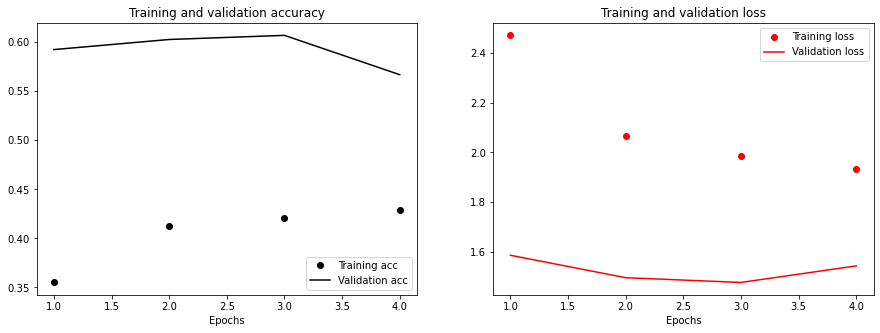

In [91]:
plot_results(history_inv3)

#### Fine-Tuning

In [33]:
inception_v3.trainable = True

for layer in inception_v3.layers[:249]:
    layer.trainable = False
for layer in inception_v3.layers[249:]:
    layer.trainable = True

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['accuracy'])

model_inv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)               

In [34]:
%%time


history_inv3 = model_inv3.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv]
)

Epoch 1/4
637/637 [==============================] - 976s 2s/step - loss: 1.7348 - accuracy: 0.5151 - val_loss: 1.2227 - val_accuracy: 0.6329

Epoch 00001: val_accuracy improved from 0.60690 to 0.63286, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 2/4
637/637 [==============================] - 983s 2s/step - loss: 1.4975 - accuracy: 0.5684 - val_loss: 1.0872 - val_accuracy: 0.6672

Epoch 00002: val_accuracy improved from 0.63286 to 0.66716, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 3/4
637/637 [==============================] - 959s 2s/step - loss: 1.3855 - accuracy: 0.5954 - val_loss: 0.9946 - val_accuracy: 0.6835

Epoch 00003: val_accuracy improved from 0.66716 to 0.68352, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 4/4
637/637 [==============================] - 955s 1s/step - loss: 1.2462 - accuracy: 0.6311 - val_loss: 0.8025 - val_accuracy: 0.7600

Epoch 00004: val_accuracy improved from 0.68352 to 0.76004, saving model to ./savefiles/model_inv3_wts.h

In [35]:
model_inv3.load_weights(filepath_inv)

model_inv3.save(save_dir + '/inception_v3_ft.h5')

with open(save_dir + '/inception_v3_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_inv3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

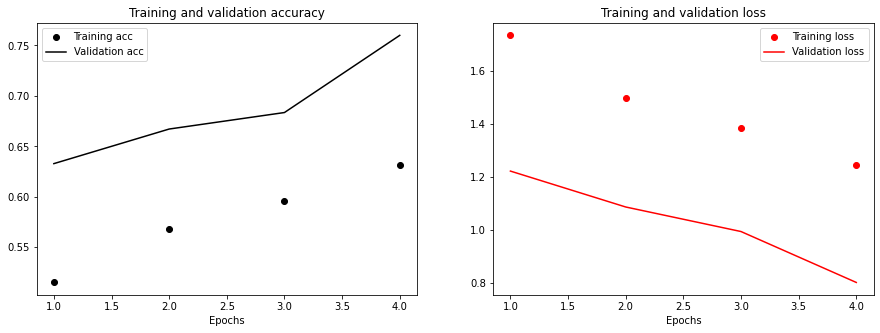

In [36]:
plot_results(history_inv3)

### Transfer Learning with VGG16 + Fine-Tuning

Next, the VGG16 model was trained and fine-tuning was performed.

In [39]:
tf.keras.backend.clear_session()

#### Train of the top layers

In [40]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False)

vgg16.trainable = False

model_vgg16 = models.Sequential()
model_vgg16.add(layers.Lambda(preprocess_vgg16,
                             input_shape=(target_size, target_size, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation="relu"))
model_vgg16.add(layers.Dropout(0.6))
model_vgg16.add(layers.Dense(num_classes, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 23,110,234
Trainable params: 8,395,546
Non-trainable params: 14,714,688
____________________________________

In [41]:
%%time

filepath_vgg = save_dir + "/model_vgg16_wts.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_vgg16 = model_vgg16.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_vgg]
)

Epoch 1/4
637/637 [==============================] - 1196s 2s/step - loss: 2.9621 - accuracy: 0.3615 - val_loss: 1.7824 - val_accuracy: 0.4866

Epoch 00001: val_accuracy improved from -inf to 0.48658, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1053s 2s/step - loss: 2.1536 - accuracy: 0.4065 - val_loss: 1.5539 - val_accuracy: 0.5666

Epoch 00002: val_accuracy improved from 0.48658 to 0.56663, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1180s 2s/step - loss: 1.9993 - accuracy: 0.4341 - val_loss: 1.4792 - val_accuracy: 0.5995

Epoch 00003: val_accuracy improved from 0.56663 to 0.59955, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 4/4
637/637 [==============================] - 1097s 2s/step - loss: 1.8966 - accuracy: 0.4623 - val_loss: 1.4065 - val_accuracy: 0.6117

Epoch 00004: val_accuracy improved from 0.59955 to 0.61170, saving model to ./savefiles/model_vgg16_

In [42]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16.h5')

with open(save_dir + '/vgg16_hist.pickle', 'wb') as handle:
    pickle.dump(history_vgg16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

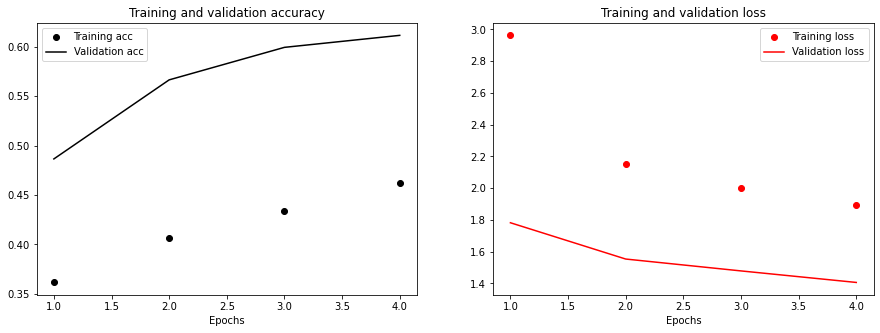

In [93]:
plot_results(history_vgg16)

#### Fine-Tuning

In [70]:
vgg16.trainable = True

for layer in vgg16.layers[:15]:
    layer.trainable = False
for layer in vgg16.layers[15:]:
    layer.trainable = True
    
model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-5),
                   metrics=['accuracy'])

model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 23,110,234
Trainable params: 15,474,970
Non-trainable params: 7,635,264
____________________________________

In [44]:
%%time

history_vgg16 = model_vgg16.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_vgg]
)

Epoch 1/4
637/637 [==============================] - 1701s 3s/step - loss: 1.7645 - accuracy: 0.5030 - val_loss: 1.3234 - val_accuracy: 0.6373

Epoch 00001: val_accuracy improved from 0.61170 to 0.63727, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1805s 3s/step - loss: 1.6662 - accuracy: 0.5261 - val_loss: 1.2855 - val_accuracy: 0.6380

Epoch 00002: val_accuracy improved from 0.63727 to 0.63796, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1601s 3s/step - loss: 1.5975 - accuracy: 0.5477 - val_loss: 1.2556 - val_accuracy: 0.6423

Epoch 00003: val_accuracy improved from 0.63796 to 0.64227, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 4/4
637/637 [==============================] - 1694s 3s/step - loss: 1.5212 - accuracy: 0.5654 - val_loss: 1.2187 - val_accuracy: 0.6488

Epoch 00004: val_accuracy improved from 0.64227 to 0.64883, saving model to ./savefiles/model_vgg

In [45]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16_ft.h5')

with open(save_dir + '/vgg16_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_vgg16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

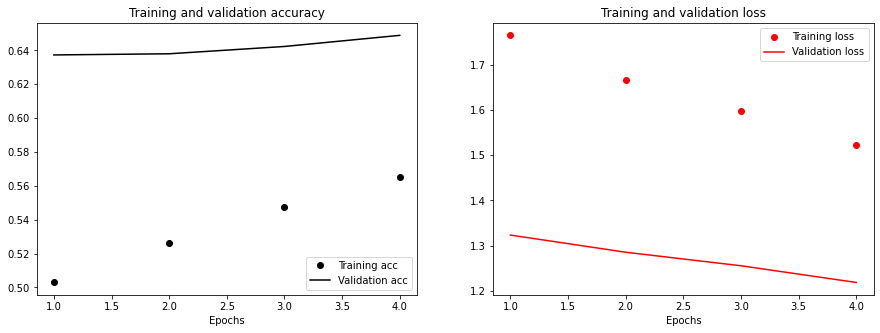

In [46]:
plot_results(history_vgg16)

### Transfer Learning with EfficientNet + Fine-Tuning

The next model to be trained and fine-tuned would be EfficientNet B0.

In [49]:
tf.keras.backend.clear_session()

#### Train of the top layers

In [93]:
effnetb0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(target_size, target_size, 3))

effnetb0.trainable = False

model_effb0 = models.Sequential()

model_effb0.add(effnetb0)
model_effb0.add(layers.Flatten())
model_effb0.add(layers.Dense(256, activation="relu"))
model_effb0.add(layers.Dropout(0.6))
model_effb0.add(layers.Dense(num_classes, activation='softmax'))

model_effb0.summary()

model_effb0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten_3 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               20971776  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 26)                6682      
Total params: 25,028,029
Trainable params: 20,978,458
Non-trainable params: 4,049,571
_________________________________________________________________


In [51]:
%%time

filepath_eff = save_dir + "/model_effb0.hdf5"
checkpoint_eff = ModelCheckpoint(filepath_eff, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_effb0 = model_effb0.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_eff]
)

Epoch 1/4
637/637 [==============================] - 1747s 3s/step - loss: 2.2952 - accuracy: 0.4573 - val_loss: 1.2088 - val_accuracy: 0.6345

Epoch 00001: val_accuracy improved from -inf to 0.63453, saving model to ./savefiles/model_effb0.hdf5
Epoch 2/4
637/637 [==============================] - 1938s 3s/step - loss: 1.7165 - accuracy: 0.5267 - val_loss: 1.1209 - val_accuracy: 0.6396

Epoch 00002: val_accuracy improved from 0.63453 to 0.63962, saving model to ./savefiles/model_effb0.hdf5
Epoch 3/4
637/637 [==============================] - 1610s 3s/step - loss: 1.5669 - accuracy: 0.5508 - val_loss: 1.0995 - val_accuracy: 0.6451

Epoch 00003: val_accuracy improved from 0.63962 to 0.64511, saving model to ./savefiles/model_effb0.hdf5
Epoch 4/4
637/637 [==============================] - 1819s 3s/step - loss: 1.5004 - accuracy: 0.5657 - val_loss: 1.0475 - val_accuracy: 0.6725

Epoch 00004: val_accuracy improved from 0.64511 to 0.67255, saving model to ./savefiles/model_effb0.hdf5
CPU tim

In [79]:
model_effb0.load_weights(filepath_eff)

model_effb0.save(save_dir + '/effb0.h5')

with open(save_dir + '/effb0_hist.pickle', 'wb') as handle:
    pickle.dump(history_effb0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

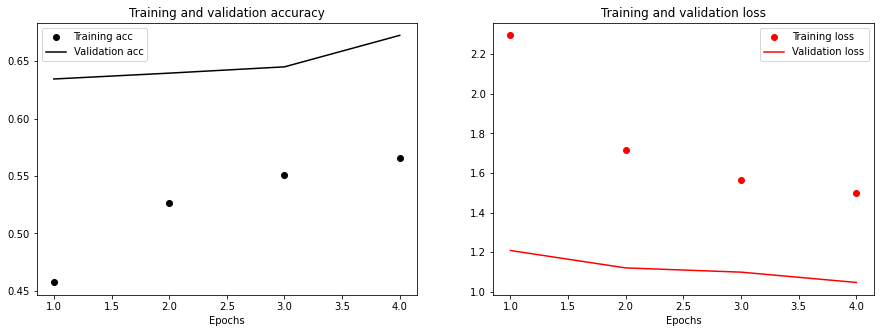

In [94]:
plot_results(history_effb0)

#### Fine-Tuning

In [101]:
effnetb0.trainable = True

for layer in effnetb0.layers[:-20]:
    layer.trainable = False
for layer in effnetb0.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_effb0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_effb0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               20971776  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 25,028,029
Trainable params: 22,329,418
Non-trainable params: 2,698,611
_________________________________________________________________


In [103]:
%%time

history_effb0 = model_effb0.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_eff]
)

Epoch 1/4
637/637 [==============================] - 1142s 2s/step - loss: 1.5856 - accuracy: 0.5432 - val_loss: 1.0753 - val_accuracy: 0.6478

Epoch 00001: val_accuracy improved from -inf to 0.64776, saving model to ./savefiles/model_effb0.hdf5
Epoch 2/4
637/637 [==============================] - 1117s 2s/step - loss: 1.4995 - accuracy: 0.5636 - val_loss: 1.0008 - val_accuracy: 0.6745

Epoch 00002: val_accuracy improved from 0.64776 to 0.67451, saving model to ./savefiles/model_effb0.hdf5
Epoch 3/4
637/637 [==============================] - 1087s 2s/step - loss: 1.4593 - accuracy: 0.5733 - val_loss: 0.9910 - val_accuracy: 0.6918

Epoch 00003: val_accuracy improved from 0.67451 to 0.69185, saving model to ./savefiles/model_effb0.hdf5
Epoch 4/4
637/637 [==============================] - 1100s 2s/step - loss: 1.4314 - accuracy: 0.5797 - val_loss: 0.9713 - val_accuracy: 0.6996

Epoch 00004: val_accuracy improved from 0.69185 to 0.69959, saving model to ./savefiles/model_effb0.hdf5
CPU tim

In [105]:
model_effb0.load_weights(filepath_eff)

model_effb0.save(save_dir + '/effb0_ft.h5')

with open(save_dir + '/effb0_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_effb0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

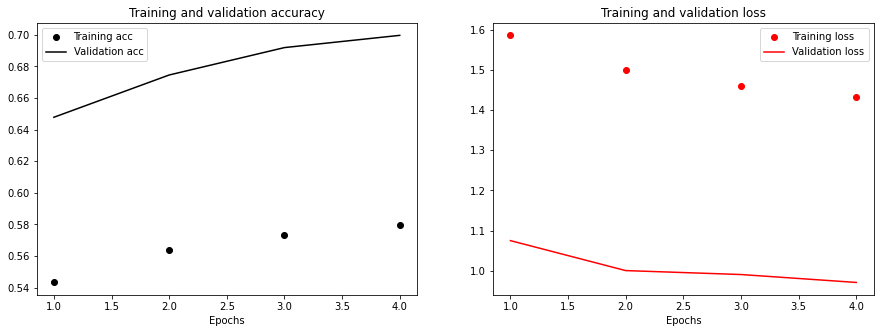

In [106]:
plot_results(history_effb0)

### CoAtNet + Fine-Tuning

The fourth model to be trained and fine-tuned (excluding the baseline CNN model) would be CoAtNet 0.

In [53]:
# !pip install -U keras-cv-attention-models
import keras_cv_attention_models

#### Train of the top layers

In [55]:
tf.keras.backend.clear_session()

In [56]:
coatnet0 = keras_cv_attention_models.coatnet.CoAtNet0(
    num_classes=0,
    input_shape=(alt_target_size, alt_target_size, 3))

coatnet0.trainable = False

model_coat0 = models.Sequential()

model_coat0.add(coatnet0)
model_coat0.add(layers.Flatten())
model_coat0.add(layers.Dense(256, activation="relu"))
model_coat0.add(layers.Dropout(0.6))
model_coat0.add(layers.Dense(num_classes, activation='softmax'))

model_coat0.summary()

model_coat0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/coatnet0_224_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 9,640,730
Non-trainable params: 23,075,178
_________________________________________________________________


In [57]:
%%time

filepath_coat = save_dir + "/model_coat0.hdf5"
checkpoint_coat = ModelCheckpoint(filepath_coat, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_coat0 = model_coat0.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_coat]
)

Epoch 1/4
637/637 [==============================] - 1536s 2s/step - loss: 2.1955 - accuracy: 0.4557 - val_loss: 1.2045 - val_accuracy: 0.6204

Epoch 00001: val_accuracy improved from -inf to 0.62042, saving model to ./savefiles/model_coat0.hdf5
Epoch 2/4
637/637 [==============================] - 1521s 2s/step - loss: 1.7330 - accuracy: 0.5098 - val_loss: 1.1471 - val_accuracy: 0.6239

Epoch 00002: val_accuracy improved from 0.62042 to 0.62395, saving model to ./savefiles/model_coat0.hdf5
Epoch 3/4
637/637 [==============================] - 1524s 2s/step - loss: 1.6252 - accuracy: 0.5244 - val_loss: 1.0837 - val_accuracy: 0.6318

Epoch 00003: val_accuracy improved from 0.62395 to 0.63179, saving model to ./savefiles/model_coat0.hdf5
Epoch 4/4
637/637 [==============================] - 1531s 2s/step - loss: 1.5472 - accuracy: 0.5337 - val_loss: 1.0859 - val_accuracy: 0.6228

Epoch 00004: val_accuracy did not improve from 0.63179
CPU times: user 1h 35min 48s, sys: 5min 23s, total: 1h 41

In [58]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0.h5')

with open(save_dir + '/coat0_hist.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

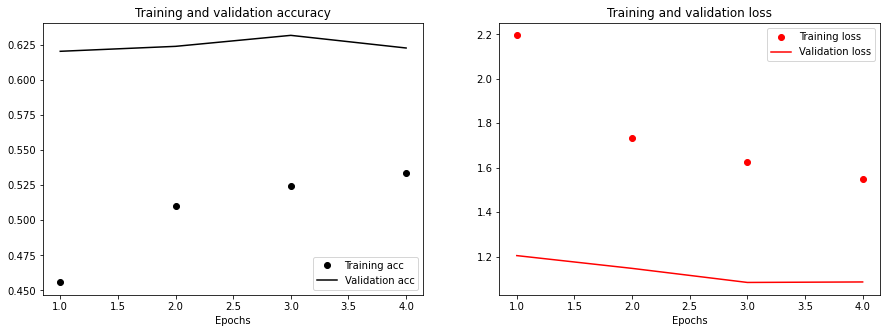

In [95]:
plot_results(history_coat0)

#### Fine-Tuning

In [120]:
coatnet0.trainable = True


for layer in coatnet0.layers[:-7]:
    layer.trainable = False
for layer in coatnet0.layers[-7:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
model_coat0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_coat0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 14,950,682
Non-trainable params: 17,765,226
_________________________________________________________________


In [121]:
%%time


history_coat0 = model_coat0.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_coat]
)

Epoch 1/4
637/637 [==============================] - 923s 1s/step - loss: 1.5093 - accuracy: 0.5453 - val_loss: 1.0558 - val_accuracy: 0.6326

Epoch 00001: val_accuracy improved from -inf to 0.63257, saving model to ./savefiles/model_coat0.hdf5
Epoch 2/4
637/637 [==============================] - 1046s 2s/step - loss: 1.4796 - accuracy: 0.5513 - val_loss: 1.0388 - val_accuracy: 0.6374

Epoch 00002: val_accuracy improved from 0.63257 to 0.63737, saving model to ./savefiles/model_coat0.hdf5
Epoch 3/4
637/637 [==============================] - 940s 1s/step - loss: 1.4521 - accuracy: 0.5565 - val_loss: 1.0402 - val_accuracy: 0.6365

Epoch 00003: val_accuracy did not improve from 0.63737
Epoch 4/4
637/637 [==============================] - 889s 1s/step - loss: 1.4314 - accuracy: 0.5630 - val_loss: 1.0313 - val_accuracy: 0.6406

Epoch 00004: val_accuracy improved from 0.63737 to 0.64060, saving model to ./savefiles/model_coat0.hdf5
CPU times: user 59min 26s, sys: 4min 17s, total: 1h 3min 43s

In [122]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0_ft.h5')

with open(save_dir + '/coat0_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

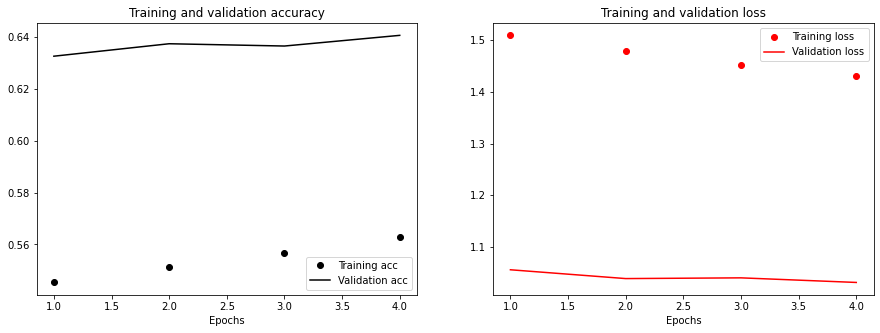

In [89]:
plot_results(history_coat0)

### LeViT + Fine-Tuning

Finally, the LeViT 192 model is trained and fine-tuned, similar to the pipeline used for the other previous architectures.

In [59]:
tf.keras.backend.clear_session()

#### Train of the top layers

In [60]:
levit192 = keras_cv_attention_models.levit.LeViT128(
    num_classes=0,
    input_shape=(alt_target_size, alt_target_size, 3))

levit192.trainable = False

model_levit = models.Sequential()

model_levit.add(levit192)
model_levit.add(layers.Flatten())
model_levit.add(layers.Dense(256, activation="relu"))
model_levit.add(layers.Dropout(0.6))
model_levit.add(layers.Dense(num_classes, activation='softmax'))

model_levit.summary()

model_levit.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/levit128_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 1,579,802
Non-trainable params: 8,489,472
_________________________________________________________________


In [61]:
%%time

filepath_lev = save_dir + "/model_levit.hdf5"
checkpoint_lev = ModelCheckpoint(filepath_lev, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_levit = model_levit.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_lev]
)

Epoch 1/4
637/637 [==============================] - 1311s 2s/step - loss: 2.1482 - accuracy: 0.4920 - val_loss: 1.1756 - val_accuracy: 0.6484

Epoch 00001: val_accuracy improved from -inf to 0.64844, saving model to ./savefiles/model_levit.hdf5
Epoch 2/4
637/637 [==============================] - 830s 1s/step - loss: 1.5523 - accuracy: 0.5725 - val_loss: 1.0507 - val_accuracy: 0.6656

Epoch 00002: val_accuracy improved from 0.64844 to 0.66559, saving model to ./savefiles/model_levit.hdf5
Epoch 3/4
637/637 [==============================] - 863s 1s/step - loss: 1.3950 - accuracy: 0.6067 - val_loss: 0.9770 - val_accuracy: 0.6977

Epoch 00003: val_accuracy improved from 0.66559 to 0.69773, saving model to ./savefiles/model_levit.hdf5
Epoch 4/4
637/637 [==============================] - 847s 1s/step - loss: 1.3329 - accuracy: 0.6159 - val_loss: 0.9202 - val_accuracy: 0.7052

Epoch 00004: val_accuracy improved from 0.69773 to 0.70517, saving model to ./savefiles/model_levit.hdf5
CPU times:

In [62]:
model_levit.load_weights(filepath_lev)

model_levit.save(save_dir + '/levit.h5')

with open(save_dir + '/levit_hist.pickle', 'wb') as handle:
    pickle.dump(history_levit.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

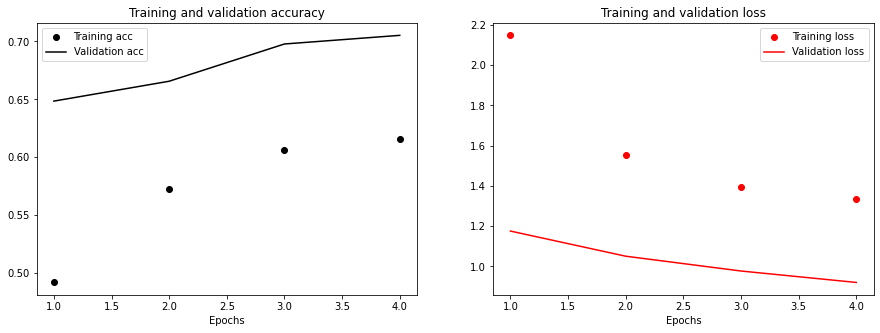

In [96]:
plot_results(history_levit)

#### Fine-Tuning

In [115]:
levit192.trainable = True

for layer in levit192.layers[:-8]:
    layer.trainable = False
for layer in levit192.layers[-8:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_levit.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_levit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 2,171,930
Non-trainable params: 7,897,344
_________________________________________________________________


In [117]:
%%time


history_levit = model_levit.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_lev]
)

Epoch 1/4
637/637 [==============================] - 935s 1s/step - loss: 1.3234 - accuracy: 0.6242 - val_loss: 0.9673 - val_accuracy: 0.6886

Epoch 00001: val_accuracy did not improve from 0.70517
Epoch 2/4
637/637 [==============================] - 906s 1s/step - loss: 1.2779 - accuracy: 0.6337 - val_loss: 0.9448 - val_accuracy: 0.6965

Epoch 00002: val_accuracy did not improve from 0.70517
Epoch 3/4
637/637 [==============================] - 1403s 2s/step - loss: 1.2498 - accuracy: 0.6394 - val_loss: 0.9280 - val_accuracy: 0.7026

Epoch 00003: val_accuracy did not improve from 0.70517
Epoch 4/4
637/637 [==============================] - 978s 2s/step - loss: 1.2323 - accuracy: 0.6419 - val_loss: 0.9064 - val_accuracy: 0.7094

Epoch 00004: val_accuracy improved from 0.70517 to 0.70939, saving model to ./savefiles/model_levit.hdf5
CPU times: user 1h 55s, sys: 4min 15s, total: 1h 5min 10s
Wall time: 1h 10min 23s


In [118]:
model_levit.load_weights(filepath_lev)

model_levit.save(save_dir + '/levit_ft.h5')

with open(save_dir + '/levit_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_levit.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

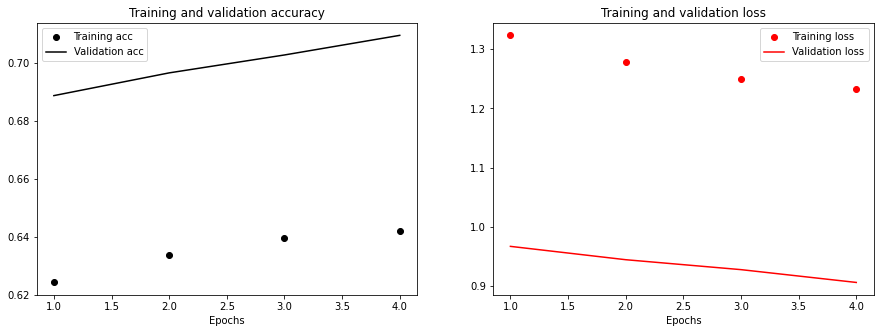

In [119]:
plot_results(history_levit)

### Summary of Model Evaluations

Upon comparing the performance of all the models, it may be observed that all the models beat the baseline CNN model throughout their initial 4 epochs. Interestingly, while Inception V3 had a modest start, by the end of 8 epochs its validation accuracy increased considerably after some base models layers were unfrozen, handily surpassing the performance of all the other architectures at 76%.  In comparison, the performance of the other models during the fine-tuning stage was more steady--regardless of the learning rate used, based on iterated attempts.

The second-best performing model was LeViT192, followed closely by EfficientNetB0, both at roughly around 70%. Falling somewhat behind at approximately 65% were CoAtNet0 and VGG16.

Incidentally, it was observed during various iterations that CoAtNet's performance was inconsistent--in some early attempts, it had actually performed quite well, but seemingly due to randomization in model training, when the model was retrained one final time (without varying any hyperparameters) in preparation for this report, it underperformed compared to the others.

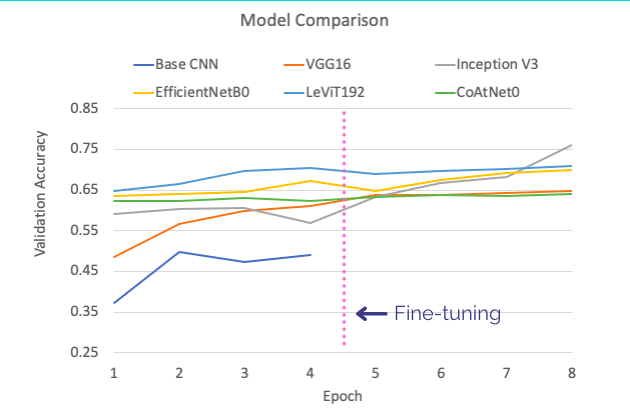

In [107]:
img = IPyImage('plot_line.png')
display(img)

The performance gains during fine-tuning is perhaps better seen in the below bar graph, where it can be seen that InceptionV3 benefit the most from unfreezing some layers. The hybrid transformer models plateaued more quickly with minimal gains, if any, in the last 4 epochs.

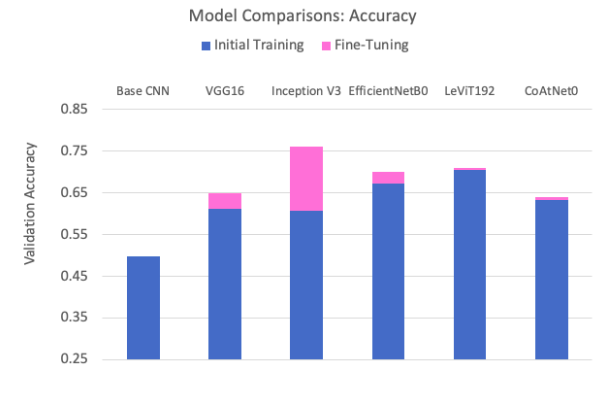

In [108]:
img = IPyImage('plot_bar.png')
display(img)

In terms of runtime, LeViT192 and Inception V3 were closely tied. This may very well be due to the relative simplicity baked into their models. LeViT had the fewest parameters among all the models and is designed with gradually decreasing resolutions, while InceptionV3 was designed to be as efficient as possible through aggressive regularization. It is also suggestive that the two fastest models had the best overall performance, indicating that a simpler model may be better for this dataset, to avoid overfitting.

That said, there is also the possibility of some variation in computing resources at the time, since this analyst observed a certain period during which all execution times appeared much longer than usual compared to all previous trials for no clear cause. It was during this period that CoAtNet0, EfficientNetB0 and VGG16 were trained for the final time in preparation fort his report.

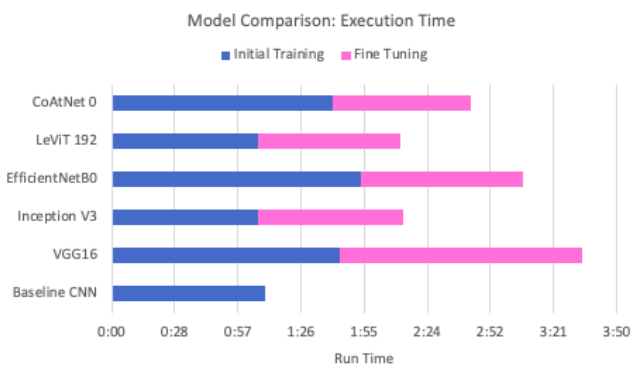

In [109]:
img = IPyImage('plot_runtimes.png')
display(img)

In any case, based on the model evaluation, InceptionV3 was selected as the winner among the architectures, and the analyst proceeded to further tune and train this model to achieve better performance, first on species identification, and then on individual identification.

## Inception V3 for Species Classification

Having selected InceptionV3 as the preferred model, this architecture was explored in greater detail. More performance metrics was added, including Top-5 Accuracy and Top-5 MAP, as inspired by the competition evaluation metrics which would be looking at the mean average precision of the top 5 prediction on individual identification.

Other features built into the pipeline were ReduceLRonPlateau (to slow down the learning rate when the gradients become too low thus helping the model find the local optima), and EarlyStopping, to save time in case no further improvements could be found after several epochs.

The model was retrained again, this time with the top base layers unfrozen from the onset. As expected, the performance was greatly improved, with over 80% accuracy from the very first epoch, and culminating in 93.34% Top-1 Accuracy and 99.37% in Top-5 Accuracy by the fifteenth and final epoch, at which time EarlyStopping took effect.

In [124]:
more_epochs = 10
tf.keras.backend.clear_session()

#### Training

In [125]:
inception_v3_base = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = "imagenet")

for layer in inception_v3_base.layers[:249]:
    layer.trainable = False
for layer in inception_v3_base.layers[249:]:
    layer.trainable = True


model_inv3_main = models.Sequential()
model_inv3_main.add(layers.Lambda(preprocess_inception_v3,
                             input_shape=(target_size, target_size, 3)))
model_inv3_main.add(inception_v3_base)
model_inv3_main.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3_main.add(layers.Flatten())
model_inv3_main.add(layers.Dense(256, activation="relu"))
model_inv3_main.add(layers.Dropout(0.6))
model_inv3_main.add(layers.Dense(num_classes, activation='softmax'))

model_inv3_main.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6

In [126]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_inv3_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [128]:
%%time

filepath_inv3b = save_dir + "/inv3_main_wts.hdf5"
checkpoint_inv3b = ModelCheckpoint(filepath_inv3b, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop_inv3b = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr_inv3b = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

history_inv3_main = model_inv3_main.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3b, earlystop_inv3b, reduce_lr_inv3b]
)

Epoch 1/10
637/637 [==============================] - 1083s 2s/step - loss: 1.3080 - accuracy: 0.6628 - top_5_acc: 0.8821 - top_5_map: 0.1764 - val_loss: 0.6702 - val_accuracy: 0.8184 - val_top_5_acc: 0.9615 - val_top_5_map: 0.1923

Epoch 00001: val_accuracy improved from -inf to 0.81844, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 2/10
637/637 [==============================] - 1011s 2s/step - loss: 0.7614 - accuracy: 0.7882 - top_5_acc: 0.9516 - top_5_map: 0.1903 - val_loss: 0.5088 - val_accuracy: 0.8587 - val_top_5_acc: 0.9756 - val_top_5_map: 0.1951

Epoch 00002: val_accuracy improved from 0.81844 to 0.85871, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 3/10
637/637 [==============================] - 1007s 2s/step - loss: 0.6358 - accuracy: 0.8212 - top_5_acc: 0.9646 - top_5_map: 0.1929 - val_loss: 0.4205 - val_accuracy: 0.8768 - val_top_5_acc: 0.9816 - val_top_5_map: 0.1963

Epoch 00003: val_accuracy improved from 0.85871 to 0.87684, saving model to ./savefiles/in

In [130]:
model_inv3_main.load_weights(filepath_inv3b)

model_inv3_main.save(save_dir + '/inv3_main.h5')

with open(save_dir + '/inv3_hist_main.pickle', 'wb') as handle:
    pickle.dump(history_inv3_main.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [146]:
def plot_results_v2(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax[0, 0].plot(epochs, acc, 'ko', label='Training Accuracy')
    ax[0, 0].plot(epochs, val_acc, 'k', label='Validation Accuracy')
    ax[0, 0].set_title('Training and Validation Categorical Accuracy')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].legend()

    # plot Top-5 Accuracy
    top_5_acc = history.history['top_5_acc']
    val_top_5_acc = history.history['val_top_5_acc']

    ax[1, 0].plot(epochs, top_5_acc, 'ko', label='Training Top-5 Accuracy')
    ax[1, 0].plot(epochs, val_top_5_acc, 'k', label='Validation Top-5 Accuracy')
    ax[1, 0].set_title('Training and Validation Top-5 Accuracy')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].legend()

    # plot Top-5 MAP
    top_5_map = history.history['top_5_map']
    val_top_5_map = history.history['val_top_5_map']

    ax[0, 1].plot(epochs, top_5_map, 'ko', label="Training Top-5 MAP")
    ax[0, 1].plot(epochs, val_top_5_map, 'k', label="Validation Top-5 MAP")
    ax[0, 1].set_title("Training and Validation Top-5 MAP")
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax[1, 1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1, 1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1, 1].set_title('Training and Validation Categorical Cross-Entropy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].legend()

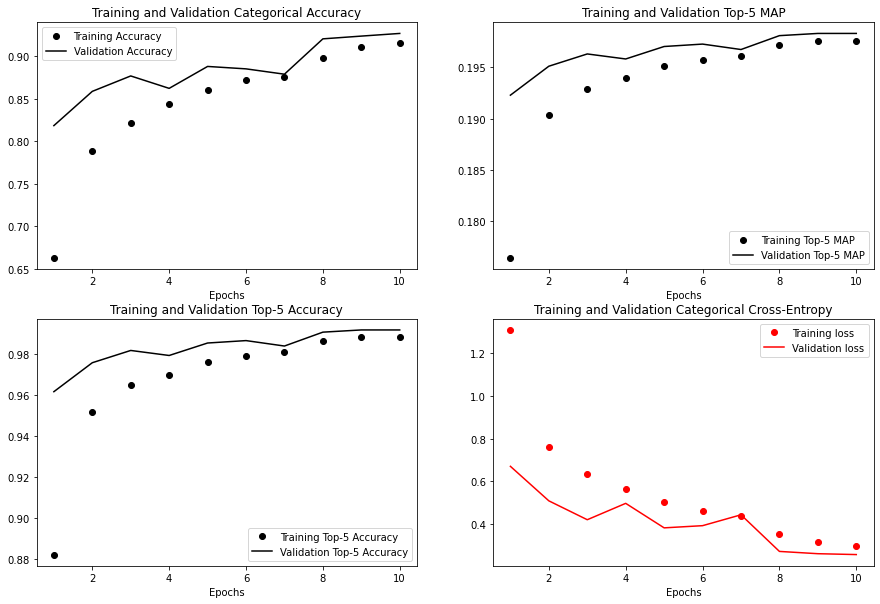

In [150]:
plot_results_v2(history_inv3_main)

#### Fine-tuning

In [135]:
model_inv3_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(learning_rate=1e-4),
                         metrics=metrics)

In [136]:
%%time

reduce_lr_inv3b = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)


history_inv3_main_ft = model_inv3_main.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3b, earlystop_inv3b, reduce_lr_inv3b]
)

Epoch 1/10
637/637 [==============================] - 984s 2s/step - loss: 0.2737 - accuracy: 0.9226 - top_5_acc: 0.9905 - top_5_map: 0.1981 - val_loss: 0.2538 - val_accuracy: 0.9319 - val_top_5_acc: 0.9929 - val_top_5_map: 0.1986

Epoch 00001: val_accuracy improved from 0.92681 to 0.93190, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 2/10
637/637 [==============================] - 928s 1s/step - loss: 0.2686 - accuracy: 0.9234 - top_5_acc: 0.9901 - top_5_map: 0.1980 - val_loss: 0.2337 - val_accuracy: 0.9334 - val_top_5_acc: 0.9928 - val_top_5_map: 0.1986

Epoch 00002: val_accuracy improved from 0.93190 to 0.93337, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 3/10
637/637 [==============================] - 952s 1s/step - loss: 0.2591 - accuracy: 0.9255 - top_5_acc: 0.9909 - top_5_map: 0.1982 - val_loss: 0.2282 - val_accuracy: 0.9334 - val_top_5_acc: 0.9937 - val_top_5_map: 0.1987

Epoch 00003: val_accuracy did not improve from 0.93337
Epoch 4/10
637/637 [===============

In [137]:
model_inv3_main.load_weights(filepath_inv3b)

model_inv3_main.save(save_dir + '/inv3_main_ft.h5')

with open(save_dir + '/inv3_hist_main_ft.pickle', 'wb') as handle:
    pickle.dump(history_inv3_main_ft.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

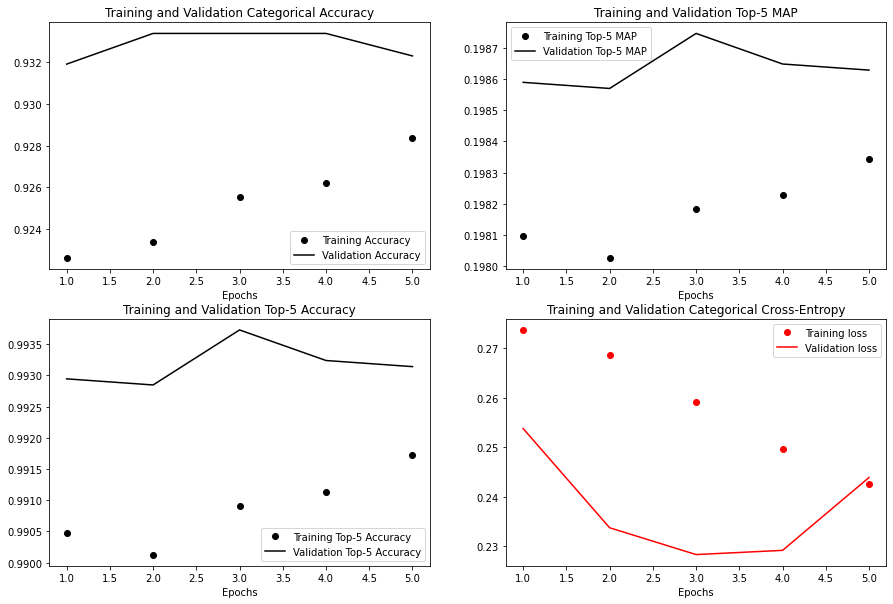

In [153]:
plot_results_v2(history_inv3_main_ft)

## Inception V3 for Individual Identification

Building a model for species identification was deemed a success, but in fulfillment of the a secondary objective of this study, the chosen model was adapted for individual identification.

Considering that the model would need to be able to consider very subtle differences in fin shape and markings, it was attempted to incerase the model input resolution to 384x384, and the ouput layer needed to be modified to include 15,587 nodes, one for each class label. 

Unfortunately, these changes made it quickly apparent that time and computing resources may be somewhat constrained for building an effective individual classifier. One epoch alone would take nearly an hour, and the accuracy started off at 0.0073. While this beats a naive random prediction based on the PCC, this is still nowhere near competitive-level performance.

Researching sample notebooks shared by other Happywhale competition participants, the model should ideally not rely on transfer learning, which is only reasonable considering the model needed to be very closely attuned and customized to the dataset, and be trained over hundreds of epochs.

Nonetheless, the model was trained for 10 epochs, to see what test set performance might be achieved upon submitting the resulting predictions on the competition website.

In [140]:
label_col = "individual_id"
num_label = len(df_train[label_col].value_counts())

more_epochs = 10
label_target_size = 384

In [141]:
tf.keras.backend.clear_session()

In [142]:
# Training set
label_train_datagen = ImageDataGenerator(validation_split=0.2,
                                         preprocessing_function=None,
                                         rotation_range=45,
                                         zoom_range=0.2,
                                         brightness_range=[0.6, 1.4],
                                         channel_shift_range=0.7,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest',
                                         shear_range=0.1,
                                         height_shift_range=0.1,
                                         width_shift_range=0.1)

label_train_gen = (
    label_train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=label_col,
                        color_mode='rgb',
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
label_val_datagen = ImageDataGenerator(validation_split=0.2)

label_val_gen = (
    label_val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=label_col,
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 15587 classes.
Found 10206 validated image filenames belonging to 15587 classes.


### Training

In [143]:
inception_v3_label = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = "imagenet")

for layer in inception_v3_label.layers[:249]:
    layer.trainable = False
for layer in inception_v3_label.layers[249:]:
    layer.trainable = True


model_inv3_label = models.Sequential()
model_inv3_label.add(layers.Lambda(preprocess_inception_v3,
                             input_shape=(label_target_size,
                                          label_target_size, 3)))
model_inv3_label.add(inception_v3_label)
model_inv3_label.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3_label.add(layers.Flatten())
model_inv3_label.add(layers.Dense(256, activation="relu"))
model_inv3_label.add(layers.Dropout(0.6))
model_inv3_label.add(layers.Dense(num_label, activation='softmax'))

model_inv3_label.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 384, 384, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15587)             4

In [144]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_inv3_label.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [145]:
%%time

filepath_inv3_label = save_dir + "/inv3_label_wts.hdf5"
checkpoint_inv3_label = ModelCheckpoint(filepath_inv3_label,
                                        monitor='val_accuracy',
                                        verbose=1, save_best_only=True,
                                        mode='max')
earlystop_inv3_label = EarlyStopping(monitor='val_accuracy',
                                     patience=3, verbose=1)
reduce_lr_inv3_label = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                         patience=2, min_lr=0.00001,
                                         verbose=1)

history_inv3_label = model_inv3_label.fit(
    label_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=label_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3_label, earlystop_inv3_label,
               reduce_lr_inv3_label]
)

Epoch 1/10
637/637 [==============================] - 1873s 3s/step - loss: 8.9515 - accuracy: 0.0046 - top_5_acc: 0.0160 - top_5_map: 0.0032 - val_loss: 8.6097 - val_accuracy: 0.0073 - val_top_5_acc: 0.0198 - val_top_5_map: 0.0040

Epoch 00001: val_accuracy improved from -inf to 0.00725, saving model to ./savefiles/inv3_label_wts.hdf5
Epoch 2/10
637/637 [==============================] - 1911s 3s/step - loss: 8.5408 - accuracy: 0.0071 - top_5_acc: 0.0186 - top_5_map: 0.0037 - val_loss: 8.5390 - val_accuracy: 0.0077 - val_top_5_acc: 0.0224 - val_top_5_map: 0.0045

Epoch 00002: val_accuracy improved from 0.00725 to 0.00774, saving model to ./savefiles/inv3_label_wts.hdf5
Epoch 3/10
637/637 [==============================] - 1955s 3s/step - loss: 8.4476 - accuracy: 0.0074 - top_5_acc: 0.0222 - top_5_map: 0.0044 - val_loss: 8.5796 - val_accuracy: 0.0097 - val_top_5_acc: 0.0294 - val_top_5_map: 0.0059

Epoch 00003: val_accuracy improved from 0.00774 to 0.00970, saving model to ./savefiles/

In [148]:
model_inv3_label.load_weights(filepath_inv3_label)

model_inv3_label.save(save_dir + '/inv3_label.h5')

with open(save_dir + '/inv3_hist_label.pickle', 'wb') as handle:
    pickle.dump(history_inv3_label.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

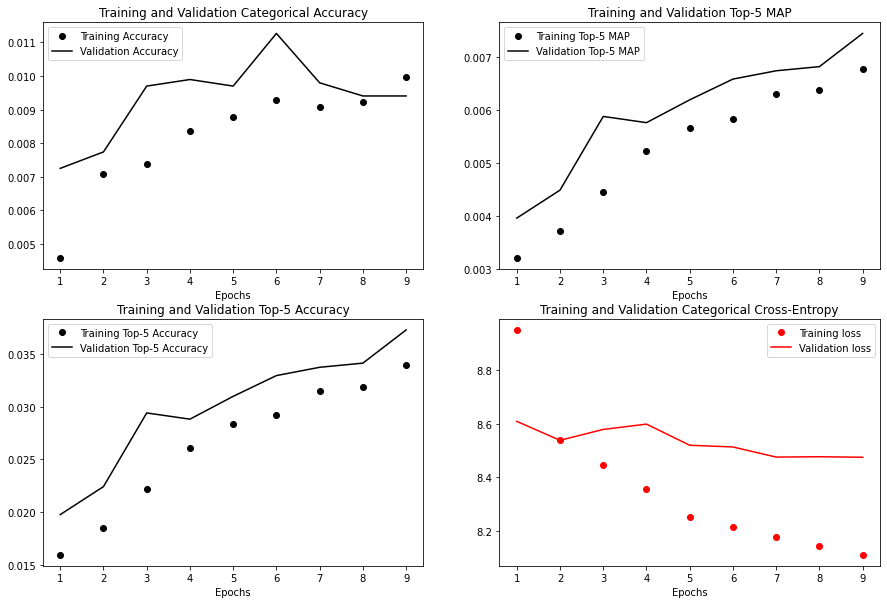

In [149]:
plot_results_v2(history_inv3_label)

### Predicting on the Test Set and Preparing a Submission

Having trained a model for individual identification (albeit for too few epochs), the model was run on the test set to allow for submission of a competition entry.

The competition requires not one but 5 predictions on each test set image, ranked in decreasing order of preference, this would be the basis for scoring based on the the Mean Average Precision @ 5 (MAP@5). [1]

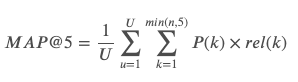

In the above formula, "𝑈 is the number of images, 𝑃(𝑘) is the precision at cutoff 𝑘, 𝑛 is the number predictions per image, and 𝑟𝑒𝑙(𝑘) is an indicator function equaling 1 if the item at rank 𝑘 is a relevant (correct) label, zero otherwise". For instance the first prediction is already correct, then entire set of prediction already earns an average score of 1.

Generating the predictions for 27956 invidivuals themselves took a fair amount of time and computational resources, and had to be done in batches to avoid out-of-memory (OOM) errors. Upon completion, it was observed that the same set of predictions were generated for every picture. This already indicates even before obtaining evaluation metrics that although a model was successfully trained to dicriminate between different species of whales and dolphins, the same could not yet be said for individual identification.

In [20]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

model_inv3_label = tf.keras.models.load_model(save_dir + '/inv3_label.h5')

In [21]:
label_target_size = 384

test = os.listdir("./jpeg-happywhale-384x384/test_images")
print(len(test))

27956


In [28]:
df_test = pd.DataFrame(test, columns=['image'])
df_test['predictions'] = ''

In [29]:
def Loading_Images(data, num, dataset):
#     print("Loading images")
    X_train = np.zeros((num, label_target_size, label_target_size, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("./jpeg-happywhale-384x384/" + dataset + "/" + fig,
                             target_size=(label_target_size, label_target_size, 3))
        x = image.img_to_array(img)
        x = preprocess_inception_v3(x)
        X_train[count] = x
        count += 1
    return X_train


def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [30]:
y, label_encoder = prepare_labels(df_train['individual_id'])

In [31]:
batch_size = 1000
batch_start = 0
batch_end = batch_size
len_df = len(df_test)


while batch_start < len_df:
    limit = min(batch_end, len_df)
    df_test_batch = df_test.iloc[batch_start:limit]
    X = Loading_Images(df_test_batch, df_test_batch.shape[0], "test_images")
    X /= 255
    predictions = model_inv3_label.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p = pred.argsort()[-5:][::-1]
        idx = -1
        s = ''
        s1 = ''
        s2 = ''
        for x in p:
            idx = idx + 1
            if pred[x] > 0.1:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s = s1 + ' new_individual' + s2
        s = s.strip(' ')
        df_test.loc[batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    print(f'Processed {limit}')
    del X
    del df_test_batch
    del predictions
    gc.collect()

100%|██████████| 1000/1000 [00:07<00:00, 127.43it/s]


32/32 [==============================] - 4s 99ms/step
Processed 1000


100%|██████████| 1000/1000 [00:07<00:00, 129.38it/s]


32/32 [==============================] - 4s 100ms/step
Processed 2000


100%|██████████| 1000/1000 [00:07<00:00, 126.76it/s]


32/32 [==============================] - 4s 99ms/step
Processed 3000


100%|██████████| 1000/1000 [00:08<00:00, 123.56it/s]


32/32 [==============================] - 4s 100ms/step
Processed 4000


100%|██████████| 1000/1000 [00:07<00:00, 130.90it/s]


32/32 [==============================] - 4s 100ms/step
Processed 5000


100%|██████████| 1000/1000 [00:07<00:00, 131.92it/s]


32/32 [==============================] - 4s 99ms/step
Processed 6000


100%|██████████| 1000/1000 [00:07<00:00, 129.41it/s]


32/32 [==============================] - 4s 100ms/step
Processed 7000


100%|██████████| 1000/1000 [00:07<00:00, 131.03it/s]


32/32 [==============================] - 4s 99ms/step
Processed 8000


100%|██████████| 1000/1000 [00:07<00:00, 126.24it/s]


32/32 [==============================] - 4s 98ms/step
Processed 9000


100%|██████████| 1000/1000 [00:07<00:00, 125.48it/s]


32/32 [==============================] - 4s 99ms/step
Processed 10000


100%|██████████| 1000/1000 [00:07<00:00, 129.20it/s]


32/32 [==============================] - 4s 98ms/step
Processed 11000


100%|██████████| 1000/1000 [00:07<00:00, 131.06it/s]


32/32 [==============================] - 4s 99ms/step
Processed 12000


100%|██████████| 1000/1000 [00:07<00:00, 131.19it/s]


32/32 [==============================] - 4s 99ms/step
Processed 13000


100%|██████████| 1000/1000 [00:07<00:00, 131.20it/s]


32/32 [==============================] - 4s 99ms/step
Processed 14000


100%|██████████| 1000/1000 [00:07<00:00, 129.65it/s]


32/32 [==============================] - 4s 100ms/step
Processed 15000


100%|██████████| 1000/1000 [00:07<00:00, 126.91it/s]


32/32 [==============================] - 4s 99ms/step
Processed 16000


100%|██████████| 1000/1000 [00:07<00:00, 130.69it/s]


32/32 [==============================] - 4s 100ms/step
Processed 17000


100%|██████████| 1000/1000 [00:07<00:00, 129.00it/s]


32/32 [==============================] - 4s 100ms/step
Processed 18000


100%|██████████| 1000/1000 [00:07<00:00, 128.32it/s]


32/32 [==============================] - 4s 100ms/step
Processed 19000


100%|██████████| 1000/1000 [00:07<00:00, 128.30it/s]


32/32 [==============================] - 4s 100ms/step
Processed 20000


100%|██████████| 1000/1000 [00:07<00:00, 127.61it/s]


32/32 [==============================] - 4s 99ms/step
Processed 21000


100%|██████████| 1000/1000 [00:07<00:00, 125.78it/s]


32/32 [==============================] - 4s 101ms/step
Processed 22000


100%|██████████| 1000/1000 [00:07<00:00, 125.83it/s]


32/32 [==============================] - 4s 100ms/step
Processed 23000


100%|██████████| 1000/1000 [00:07<00:00, 128.75it/s]


32/32 [==============================] - 4s 100ms/step
Processed 24000


100%|██████████| 1000/1000 [00:08<00:00, 121.43it/s]


32/32 [==============================] - 4s 101ms/step
Processed 25000


100%|██████████| 1000/1000 [00:08<00:00, 120.08it/s]


32/32 [==============================] - 4s 99ms/step
Processed 26000


100%|██████████| 1000/1000 [00:07<00:00, 129.42it/s]


32/32 [==============================] - 4s 100ms/step
Processed 27000


100%|██████████| 956/956 [00:07<00:00, 124.86it/s]


30/30 [==============================] - 4s 99ms/step
Processed 27956


In [32]:
df_test.to_csv('submission2.csv', index=False)
df_test

image                                        predictions
0      0453ad477acaec.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
1      0454ac14150afc.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
2      055b5053dab2f1.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
3      068bd9a7665887.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
4      078c471d482d92.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
...                   ...                                                ...
27951  8be7efa92a4fc5.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27952  a3fbacc98667b1.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27953  345c5689d879b2.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27954  fe0681ef62e5ed.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27955  ff4261d7ad84fe.jpg  37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...

[27956 rows x 2 columns]

As expected, the submitted predictions did not garner a very high score; quite the opposite in fact as the resultant score was very low. Nonetheless, the experience of simply participating in a live competition and seeing the process all the way through until submission felt rewarding, and helped one to feel a part of the global AI community.

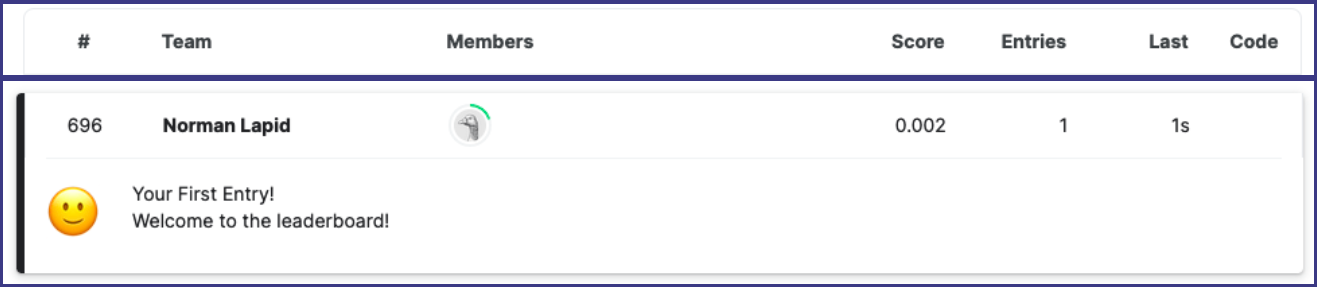

It is also worth mentioning that this analyst tried replicating some individual identification DL pipelines from the competition discussion boards. While the starting accuracy and individual per-epoch perfotmance improvement was on par with the InceptionV3 model tuned for this study (i.e. less than 1% in starting validation accuracy and only fractional percentage increases per epoch), these alternate pipelines apparently would run much faster. Indeed they were fast enough that it was possible to run numerous epochs within a reasonable timeframe. Unfortunately, despite best efforts up to and including copying the code line by line, replicating these pipelines in Jojie consistently resulted in out-of-memory and kernel death errors. For curiosity's sake, this analyst re-ran one of the shared notebooks in the Kaggle Notebooks and submitted the results on the competition to see how the test prediction score would turn out, and achieved a slightly higher result. This is something worth exploring in future iterations.

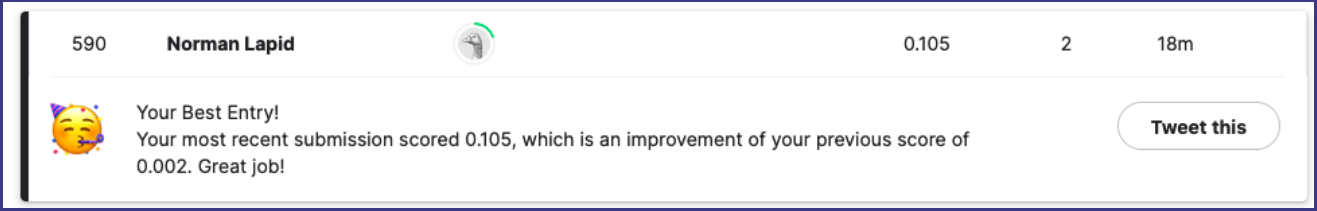

## Results and Discussion

Comparison of different deep learning models, each of which has  achieved some success in its own right, proved highly educational especially with the inclusion of newer models such as CoAtNet and LeViT. The following intuitions and hypotheses were also formed based on research concerning the different models:

*  Vision transformers are data-hungry, and CoAtNet0 in particular was designed with model capacity was a key consideration in its  design. It is highly possible that more data was needed to take advantage of its model capacity.
* While LeViT performed well, similar to CoAtNet, the newness of the architecture presented some challenges. There was no established strategy for fine-tuning either hybrid model, and they did not have specialized pre-process function unlike the models available from Keras.
* EfficientNet was designed for lightness and agility, but it is surmised there was too much tradeoff between speed and accuracy. The base model itself had few parameters and was expected to run quickly, but the dense top layer added to boost accuracy greatly increased the total number of trainable parameters. This compromise might have meant that neither metric was properly maximized. Still, it was considered highly useful to know that EfficientNet has drastically fewer trainable parameters (about 4 million compared to ~20 million for its competitors) and yet still compares in performance with other architectures.
* The performance of InceptionV3 might have been due to its inherent regularization, which prevented it from converging too early and provided it the potential to continually improve in accuracy with more epochs.

## Conclusions and Areas for Further Study

Regardless of the strengths and weaknesses of each model, each of them--including the baseline CNN model which was not pre-trained on ImageNet--proved capable of performing species identification. Similar to the tweaks done on InceptionV3 to achieve the 93.34% Top-1 Accuracy and 99.37% in Top-5 Accuracy, better performance as well as longer convergence may be reasonably expected from the other models given more time for tuning and iteration.

This was a pleasant surprise, as it was felt from a cursory examination of the dataset images appeared that even manual species identification could prove challenging. This was considering that only a small portion of each whale or dolphin was often visible in the images (and sometimes from very far away). Also there were challenging elements in the images themselves, such as noise, or low contrast between the animal and the surrounding seascape. Nonetheless, neural networks proved up to the task.

Individual whale and identification proved much more challenging, as anticipated.  Some techniques and options that can be explored to improve the performance in this regard include:
- Image cropping using YOLO
    * This was attempted, but research as well as available YOLO-cropped datasets  revealed that some images would be OOD, or out-of-distribution, resulting in false positives when it came to identifying and assigning bounding boxes to the animals. Hence it was not pursued to avoid introducing unnecessary falsely labelled images into the data. Still, further tuning and training of a YOLO architecture, or cleanup of a pre-cropped dataset may prove fruitful
- Apply on higher-resolution images
    * For the sake of efficiency and runtimes, the images were resized before being trained on the various neural nets explored above. Indeed it was found that runtimes were highly sensitive to iamge sizes. However, given the detail and nuance that might be needed to correctly identify an individual, the user of high-resolution images may be explored.
- Alternative computing resources
    * Belatedly, Kaggle Notebooks was explored in pursuit of this study and competition, and it proved attempt at running pipelines that could not be executed on Jojie. Further attempts to improve the accuracy of an individual identification model could utilize this resource. Another option is to use cloud computing services such as Amazon Web Services, as a potentially more powerful as well as scalable tool to achieve the runtime and accuracy needed to train an effective model.

## References

[1] Happywhale - Whale and Dolphin Identification | Kaggle. (2022). Kaggle. https://www.kaggle.com/c/happy-whale-and-dolphin/overview

[2] Happywhale. (2022). Happywhale. https://happywhale.com/about

[3] Szegedy, C. (2015, December 2). Rethinking the Inception Architecture for Computer Vision. arXiv.Org. https://arxiv.org/abs/1512.00567v3

[4] Simonyan, K. (2014, September 4). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv.Org. https://arxiv.org/abs/1409.1556v6

[5] Yang, B. (2019, April 10). CondConv: Conditionally Parameterized Convolutions for Efficient Inference. arXiv.Org. https://arxiv.org/abs/1904.04971v3

[6] Dai, Z. (2021, June 9). CoAtNet: Marrying Convolution and Attention for All Data Sizes. arXiv.Org. https://arxiv.org/abs/2106.04803v2

[7] Graham, B. (2021, April 2). LeViT: a Vision Transformer in ConvNet’s Clothing for Faster Inference. arXiv.Org. https://arxiv.org/abs/2104.01136v2